# Tutorial: Extracting Data

This Code contains a step by step guide on how to take an index composition reference (such as the Brazilian IBOV) and extract/format data via YaHoo finance.

It also shows how to concatenate daily data on the Brazilian Risk Free Rate via the Brazilian Central Bank API and basic operation and visualizations.

By Kevin Pergher, Decenter the 24th, 2025.

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import requests

warnings.filterwarnings("ignore")

# Use the IBOV reference of composition form 25/10/2025 to extract data from Yahoo Finance 
dataset = pd.read_csv('datasets/IBOV_23-10-25.csv', sep = ';')
dataset.index = dataset['Ticker']
dataset = dataset[['YaHoo']]

# Add the Brazilian Index Bovespa
dataset.loc['IBOV'] = ['^BVSP']

fullData = {}

# for any ticker at B3 (Brazilian Stock Exchange) "^BVSP"
for ticker, code in dataset.iterrows():

    print(f"Downloading data for {ticker} (YaHoo: {code['YaHoo']})")

    df = yf.download(code['YaHoo'], start = "2010-01-01", end = "2025-10-23", progress = False, auto_adjust = True)

    fullData[ticker] = df

# The obtained data is stored in the fullData dictionary
# This is an example of accessing the data for a specific ticker
# For example, to access data for PETR4 (Petrobras):
fullData['PETR4']


1 Failed download:
['TIMS3.SA']: Timeout('Failed to perform, curl: (28) Operation timed out after 10000 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2010-01-04,8.128472,8.128472,8.019570,8.047885,13303600
2010-01-05,8.058775,8.152431,8.015214,8.141541,21396400
2010-01-06,8.167677,8.167677,8.015213,8.015213,18720600
2010-01-07,8.091447,8.156788,8.074022,8.117583,10964600
2010-01-08,8.047885,8.143719,8.028282,8.093624,14624200
...,...,...,...,...,...
2025-10-16,28.556835,28.905916,28.518047,28.838039,28660900
2025-10-17,28.828342,29.041671,28.421080,28.605318,36238600


This code how to append SELIC daily data from the Brazilian Central Bank to perform analysis like Sharpe ratio 

In [2]:
# Extract SELIC data from the Brazilian Central Bank API
# Attention to the date format: DD/MM/YYYY - Central Bank just accepts requisitions up to 10 years ago, so change '24/12/2015' accordingly
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=24/12/2015"
data = requests.get(url).json()

selic = pd.DataFrame(data)
selic.index = pd.to_datetime(selic["data"], dayfirst=True).tolist()
selic["valor"] = selic["valor"].astype(float)/100

selic.drop(columns = ["data"], inplace=True)

# Our original series had data from before 2015-12-24, so we need to concatenate both series
originalSeries = pd.read_csv('datasets/SELIC_returns.csv', index_col = 0)
originalSeries.index = pd.to_datetime(originalSeries.index, format='%Y-%m-%d')
originalSeries = originalSeries[originalSeries.index < selic.index.min()].copy()

selic = pd.concat([originalSeries, selic.rename(columns={"valor": "SELIC"})], axis = 0)

# Save the updated SELIC returns series
selic.to_csv('datasets/SELIC_returns.csv')

selic = (1 + selic).cumprod()

selic

,SELIC
2000-01-03,1.000000
2000-01-04,1.000683
2000-01-05,1.001366
2000-01-06,1.002049
2000-01-07,1.002732
...,...
2025-12-18,19.407651
2025-12-19,19.418350
2025-12-22,19.429056
2025-12-23,19.439767


Here we transform the raw data in a matrix format where the columns stand for individual tickers and inidces and the row for trading days

In [3]:
# Crating a single DataFrame with the closing prices of all tickers
closingPrices = pd.DataFrame()

for ticker, df in fullData.items():
    aux = df['Close'].copy()
    aux.columns = [ticker]
    closingPrices = pd.concat([closingPrices, aux], axis = 1)

closingPrices.index = closingPrices.index.tolist()

# Sorting index
closingPrices.sort_index(inplace = True)

# Add the free risk interest rate (SELIC) to the closing prices DataFrame
selic = selic[selic.index.isin(closingPrices.index)].copy()
closingPrices = pd.concat([closingPrices, selic.rename(columns={"SELIC": "SELIC"})], axis = 1)

closingPrices

,ALOS3,ABEV3,ASAI3,AURE3,AZZA3,B3SA3,BBSE3,BBDC3,BBDC4,BRAP4,...,UGPA3,USIM5,VALE3,VAMO3,VBBR3,VIVA3,WEGE3,YDUQ3,IBOV,SELIC
2010-01-04,NaN,3.048629,NaN,NaN,NaN,7.346884,NaN,4.268118,6.485289,2.623851,...,1.978463,19.329044,20.094963,NaN,NaN,NaN,1.918660,5.319602,70045.0,4.434929
2010-01-05,NaN,3.066561,NaN,NaN,NaN,7.375249,NaN,4.209335,6.453370,2.676729,...,1.978463,19.385900,20.282291,NaN,NaN,NaN,1.914473,5.383322,70240.0,4.436382
2010-01-06,NaN,3.097844,NaN,NaN,NaN,7.653238,NaN,4.184538,6.401741,2.714213,...,1.978463,19.366949,20.711588,NaN,NaN,NaN,1.924940,5.471215,70729.0,4.437836
2010-01-07,NaN,3.112391,NaN,NaN,NaN,7.834782,NaN,4.174901,6.384536,2.744334,...,1.978463,19.548868,20.797445,NaN,NaN,NaN,1.957389,5.383322,70451.0,4.439291
2010-01-08,NaN,3.106412,NaN,NaN,NaN,7.653238,NaN,4.180411,6.377648,2.784495,...,1.978463,19.272196,21.000385,NaN,NaN,NaN,2.028568,5.383322,70263.0,4.440749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-16,23.341249,11.512649,8.37,10.76,22.252806,12.600000,31.809999,14.868151,17.524651,15.334014,...,20.116121,4.790000,57.300266,2.814647,21.123009,27.273619,37.095932,11.830000,142200.0,18.942658
2025-10-17,23.467995,11.721107,8.42,10.93,22.561745,12.560000,31.959999,15.017831,17.644409,15.325120,...,20.106579,4.860000,57.138725,2.824221,21.258762,28.194164,38.756226,11.970000,143399.0,18.953101
2025-10-20,23.662994,11.711632,8.42,10.80,23.125107,12.660000,32.110001,15.287252,17.973745,15.636425,...,19.944353,4.860000,57.870422,2.776353,21.340212,28.497749,38.167400,12.490000,144509.0,18.963550
2025-10-21,23.692244,11.578977,8.47,11.00,23.288664,12.330000,31.910000,15.137573,17.734228,15.565270,...,19.686697,4.960000,57.775394,2.967825,21.023458,28.928644,38.292881,12.500000,144085.0,18.974005


Save the data for your future analysis

In [4]:
# Saving to CSV
closingPrices.to_csv("datasets/IBOV_equity_closing_prices.csv")

Visualyzing the dataset

In [9]:
closingPrices[['PETR4', 'ITUB4', 'VALE3', 'BBAS3', 'WEGE3', 'SELIC', 'IBOV']].tail(10).round(2)

,PETR4,ITUB4,VALE3,BBAS3,WEGE3,SELIC,IBOV
2025-10-09,29.29,35.14,56.17,21.08,35.91,18.89,141708.0
2025-10-10,29.03,35.10,55.94,20.50,35.42,18.90,140680.0
2025-10-13,29.31,35.24,56.78,20.77,36.53,18.91,141783.0
2025-10-14,29.11,35.39,56.78,20.59,36.03,18.92,141683.0
2025-10-15,28.85,35.39,57.83,20.21,36.12,18.93,142604.0
2025-10-16,28.56,35.31,57.30,20.26,37.10,18.94,142200.0
2025-10-17,28.83,35.43,57.14,20.79,38.76,18.95,143399.0
2025-10-20,28.85,36.06,57.87,20.66,38.17,18.96,144509.0
2025-10-21,28.62,35.72,57.78,20.43,38.29,18.97,144085.0
2025-10-22,28.94,36.02,58.80,20.58,38.63,18.98,144873.0


Plotting the dataset

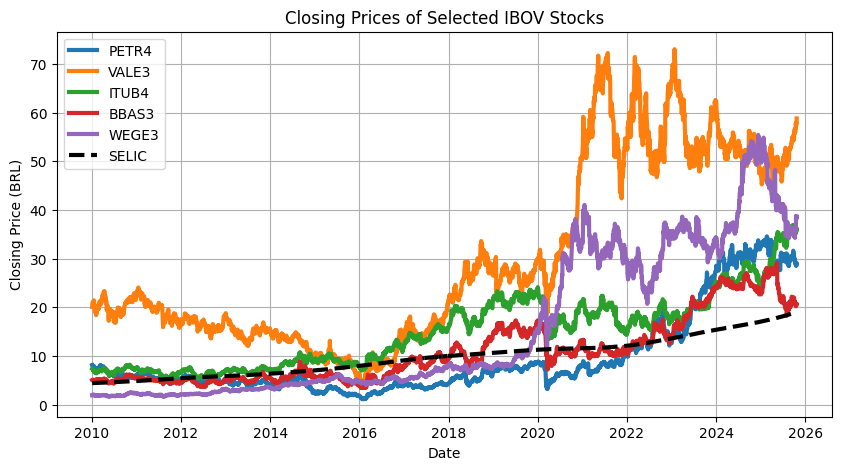

In [12]:
plt.figure(figsize=(10,5))
plt.plot(closingPrices.index, closingPrices['PETR4'], label='PETR4', lw = 3)
plt.plot(closingPrices.index, closingPrices['VALE3'], label='VALE3', lw = 3)
plt.plot(closingPrices.index, closingPrices['ITUB4'], label='ITUB4', lw = 3)
plt.plot(closingPrices.index, closingPrices['BBAS3'], label='BBAS3', lw = 3)
plt.plot(closingPrices.index, closingPrices['WEGE3'], label='WEGE3', lw = 3)
plt.plot(closingPrices.index, closingPrices['SELIC'], label='SELIC', lw = 3, ls='--', color='black')
plt.xlabel("Date")
plt.ylabel("Closing Price (BRL)")
plt.title("Closing Prices of Selected IBOV Stocks")
plt.grid()
plt.legend()

Plotting last obtained simple (linear) daily returns

In [13]:
closingPrices[['PETR4', 'ITUB4', 'VALE3', 'BBAS3', 'WEGE3', 'SELIC', 'IBOV']].pct_change().tail(10) * 100

,PETR4,ITUB4,VALE3,BBAS3,WEGE3,SELIC,IBOV
2025-10-09,-1.435567,-0.161119,-0.152025,0.331437,4.788726,0.055131,-0.307433
2025-10-10,-0.893740,-0.107586,-0.406031,-2.737134,-1.370974,0.055131,-0.725435
2025-10-13,0.968602,0.403877,1.494827,1.310037,3.134375,0.055131,0.784049
2025-10-14,-0.694672,0.429075,0.000000,-0.862062,-1.347776,0.055131,-0.070530
2025-10-15,-0.899397,0.000000,1.857737,-1.835756,0.241083,0.055131,0.650043
2025-10-16,-1.008402,-0.240329,-0.920146,0.246067,2.699099,0.055131,-0.283302
2025-10-17,0.950761,0.347976,-0.281920,2.601855,4.475676,0.055131,0.843179
2025-10-20,0.067274,1.787139,1.280562,-0.621999,-1.519305,0.055131,0.774064
2025-10-21,-0.806723,-0.943397,-0.164208,-1.107363,0.328764,0.055131,-0.293407
2025-10-22,1.152154,0.820111,1.776320,0.730275,0.882295,0.055131,0.546899
